In [1]:
import textwrap
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv("env")

llm_name = "llama-3.1-8b-instant"
# llm_name = "llama-3.1-70b-versatile"
llm = ChatGroq(cache=False, temperature=0.0, model_name=llm_name)

# import os

# config_list = [
#     {
#         # Let's choose the Llama 3 model
#         "model": "llama3-8b-8192",
#         # Put your Groq API key here or put it into the GROQ_API_KEY environment variable.
#         "api_key": os.environ.get("GROQ_API_KEY"),
#         # We specify the API Type as 'groq' so it uses the Groq client class
#         "api_type": "groq",
#     }
# ]


In [5]:
from pathlib import Path

from autogen import AssistantAgent, UserProxyAgent
from autogen.coding import LocalCommandLineCodeExecutor

# Setting up the code executor
workdir = Path("coding")
workdir.mkdir(exist_ok=True)
code_executor = LocalCommandLineCodeExecutor(work_dir=workdir)

# Setting up the agents
import os

config_list = [
    {
        # Let's choose the Llama 3 model
        "model": llm_name,
        # Put your Groq API key here or put it into the GROQ_API_KEY environment variable.
        # "api_key": os.environ.get("GROQ_API_KEY"),
        # We specify the API Type as 'groq' so it uses the Groq client class
        "api_type": "groq",
    }
]


# The UserProxyAgent will execute the code that the AssistantAgent provides
user_proxy_agent = UserProxyAgent(
    "user_proxy",
    human_input_mode="NEVER",
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    max_consecutive_auto_reply=1,
)
system_message = """You are an expert python programmer. You recieve the task, write the python code and outside the python block you write TERMINATE to end the conversation."""

# The AssistantAgent, using Groq's model, will take the coding request and return code
assistant_agent = AssistantAgent(
    name="Groq Assistant",
    system_message=system_message,
    llm_config={
    "config_list": config_list,
    },
    # system_message=system_message,
    # llm_config={"config_list": config_list},
)

In [6]:
user_proxy_agent.initiate_chat(
    assistant_agent, message="Write a python program to print the first 10 numbers of the Fibonacci sequence."
)

user_proxy (to Groq Assistant):

Write a python program to print the first 10 numbers of the Fibonacci sequence.

--------------------------------------------------------------------------------
Groq Assistant (to user_proxy):

```python
def fibonacci(n):
    fib_sequence = [0, 1]
    while len(fib_sequence) < n:
        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
    return fib_sequence[:n]

print(fibonacci(10))
```

TERMINATE

--------------------------------------------------------------------------------


/home/guess/mambaforge/envs/dspy/lib/python3.11/site-packages/autogen/oai/groq.py:280: UserWarning: Cost calculation not available for model llama-3.1-8b-instant
  warnings.warn(f"Cost calculation not available for model {model}", UserWarning)


ChatResult(chat_id=None, chat_history=[{'content': 'Write a python program to print the first 10 numbers of the Fibonacci sequence.', 'role': 'assistant'}, {'content': '```python\ndef fibonacci(n):\n    fib_sequence = [0, 1]\n    while len(fib_sequence) < n:\n        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])\n    return fib_sequence[:n]\n\nprint(fibonacci(10))\n```\n\nTERMINATE', 'role': 'user'}], summary='```python\ndef fibonacci(n):\n    fib_sequence = [0, 1]\n    while len(fib_sequence) < n:\n        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])\n    return fib_sequence[:n]\n\nprint(fibonacci(10))\n```\n\n', cost={'usage_including_cached_inference': {'total_cost': 0.0, 'llama-3.1-8b-instant': {'cost': 0.0, 'prompt_tokens': 62, 'completion_tokens': 63, 'total_tokens': 125}}, 'usage_excluding_cached_inference': {'total_cost': 0.0, 'llama-3.1-8b-instant': {'cost': 0.0, 'prompt_tokens': 62, 'completion_tokens': 63, 'total_tokens': 125}}}, human_input=[])

In [13]:
from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor

# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=".",  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="NEVER",  # Always take human input for this agent for safety.
)

In [14]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load original data
dataset_folder = "datasets/financial"
X_train_reference = pd.read_csv(f"{dataset_folder}/X_train_reference.csv")
X_test_reference = pd.read_csv(f"{dataset_folder}/X_test_reference.csv")
y_train_reference = pd.read_csv(f"{dataset_folder}/y_train_reference.csv").squeeze("columns")
y_test_reference = pd.read_csv(f"{dataset_folder}/y_test_reference.csv").squeeze("columns")

# Load new data
X_new = pd.read_csv(f"{dataset_folder}/X_test_current.csv")

# Train initial model
model_reference = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_reference.fit(X_train_reference, y_train_reference)

# Predict labels for new data
y_new_pred = model_reference.predict(X_new)

# Combine datasets
X_combined = pd.concat([X_train_reference, X_new], ignore_index=True)
y_combined = pd.concat([y_train_reference, pd.Series(y_new_pred)], ignore_index=True)

# Train new model on combined data
new_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=150, random_state=42))
])

new_model.fit(X_combined, y_combined)

# Evaluate new model on original test set
new_accuracy = new_model.score(X_test_reference, y_test_reference)
print(f'New Model Accuracy on Reference Test Set: {new_accuracy}')

# Evaluate new model on new data
new_accuracy_new_data = new_model.score(X_new, y_new_pred)
print(f'New Model Accuracy on New Data: {new_accuracy_new_data}')

# Compare with original model
initial_accuracy = model_reference.score(X_test_reference, y_test_reference)
print(f'Original Model Accuracy on Reference Test Set: {initial_accuracy}')

print(f'Improvement on Reference Test Set: {new_accuracy - initial_accuracy}')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: New Model Accuracy on Reference Test Set: 0.875
New Model Accuracy on New Data: 1.0
Original Model Accuracy on Reference Test Set: 0.91
Improvement on Reference Test Set: -0.03500000000000003



In [10]:
print(reply)

# LLM as a classifier

 Age        Income  Credit Score  Loan Amount  Loan Term  Interest Rate  Employment Length  Home Ownership  Marital Status  Dependents
  50  82601.149773           677 16755.051519         39      16.315661                 24               1               1           3
  40 101525.523244           519 18177.451386         40      12.475047                 11               1               2           1
  39  95503.116815           565 20059.158927         40      14.871822                 21               1               1           3
  53  67885.127293           561 25243.538451         24      15.352958                 22               1               2           4
  52 101501.120325           716 31573.149573         43       7.147018                 12               1               1           2
  43  94161.494367           782 29603.573635         36      15.657428                 12               1               2           2
  50  65390.054141           547 14067.480560         3

In [78]:
# read the X_train_reference.csv file and y_train_reference.csv file
import pandas as pd
X_train_reference = pd.read_csv("datasets/financial/X_train_reference.csv")
y_train_reference = pd.read_csv("datasets/financial/y_train_reference.csv").squeeze("columns")

# sample 10% of both X_train_reference and y_train_reference
fraction = 0.20
X_train_reference_sample = X_train_reference.sample(frac=fraction, random_state=42)
y_train_reference_sample = y_train_reference.loc[X_train_reference_sample.index]

# show them

# print(X_train_reference_sample.to_string(index=False))
# print(y_train_reference_sample.to_string(index=False))




In [83]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score



# Load Training Data
X_train = X_train_reference_sample
y_train = y_train_reference_sample

# Load Test Data
X_test = pd.read_csv('datasets/financial/X_test_reference.csv')
y_test = pd.read_csv('datasets/financial/y_test_reference.csv').squeeze("columns")

# Identify numerical and categorical columns
numerical_features = [
    'Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term',
    'Interest Rate', 'Employment Length'
]
categorical_features = ['Home Ownership', 'Marital Status', 'Dependents']

# Preprocessing for numerical data: imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define the machine learning pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test dataset: {accuracy:.2%}")


Accuracy on the test dataset: 85.00%


In [81]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

dataset_folder = "datasets/financial"

X_test_reference = pd.read_csv(f"{dataset_folder}/X_test_reference.csv")
y_test_reference = pd.read_csv(f"{dataset_folder}/y_test_reference.csv").squeeze("columns")

model_reference =  DecisionTreeClassifier(random_state=42)

model_reference.fit(X_train_reference_sample, y_train_reference_sample)

# Test the model on the initial test set
initial_accuracy = model_reference.score(X_test_reference, y_test_reference)
print(f'Model trained and evaluated on the reference distribution: {initial_accuracy}')

Model trained and evaluated on the reference distribution: 0.765


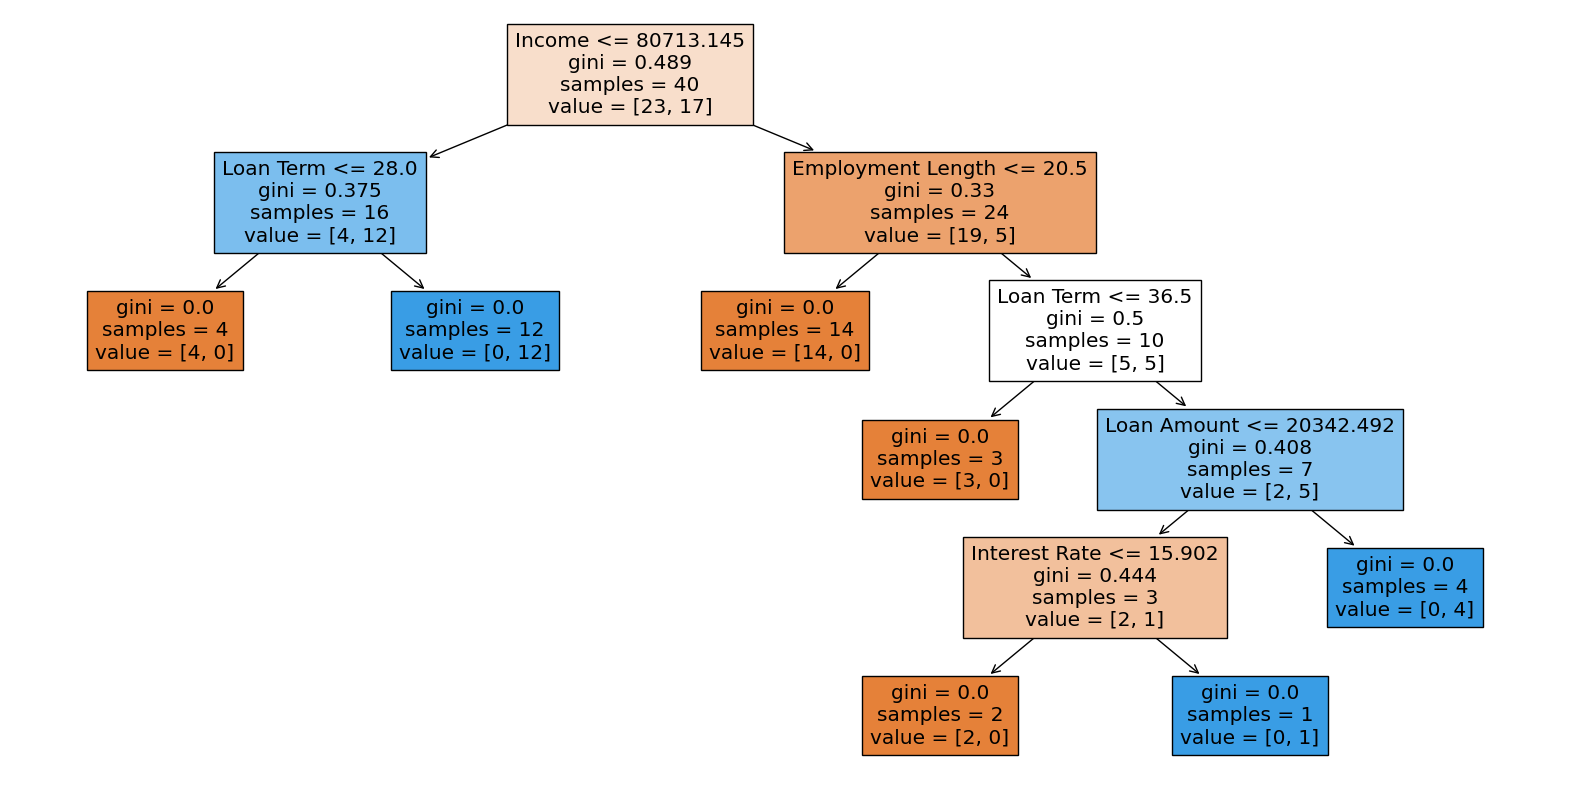

In [55]:
# get decision tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model_reference, filled=True, feature_names=X_train_reference_sample.columns)
plt.show()


In [56]:
# Load the test datasets
import pandas as pd
from sklearn.metrics import accuracy_score
X_test_reference = pd.read_csv(f"{dataset_folder}/X_test_reference.csv")
y_test_reference = pd.read_csv(f"{dataset_folder}/y_test_reference.csv").squeeze("columns")

# Ensure that 'Home Ownership', 'Marital Status', and 'Dependents' are integers (if they are categorical codes)
# categorical_columns = ['Home Ownership', 'Marital Status', 'Dependents']
# X_test_current[categorical_columns] = X_test_current[categorical_columns].astype(int)

# Apply the classifier to each row in the test dataset
predictions = X_test_reference.apply(classify_loan_default, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(y_test_reference, predictions)

print(f"Accuracy on the test dataset: {accuracy:.2%}")




Accuracy on the test dataset: 46.00%


In [ ]:
    # def measure_model_retraining_speed(self, state: WorkingMemory) -> WorkingMemory:
    #     episodic_memory = state['episodic_memory']
    #     semantic_memory = state['semantic_memory']
        
    #     num_samples = semantic_memory.reference_dataset.X_train.shape[0]
    #     num_features = semantic_memory.reference_dataset.X_train.shape[1]
    #     training_code = semantic_memory.model_code

    #     # # Get hardware specs
    #     # physical_cores = psutil.cpu_count(logical=False)
    #     # total_threads = psutil.cpu_count(logical=True)

    #     # Create the prompt for the LLM
    #     prompt = prompt_measure_model_retraining_speed()
        
    #     # Prepare the input in YAML format
    #     cleaned_code = textwrap.dedent(training_code).strip()
    #     indented_code = textwrap.indent(cleaned_code, '  ')

    #     yaml_content = (
    #         f"num_samples: {num_samples}\n"
    #         f"num_features: {num_features}\n"
    #         "training_code: |\n"
    #         f"{indented_code}\n"
    #     )

    #     # Invoke the LLM
    #     chain = prompt | self.llm
    #     output = chain.invoke({'input': yaml_content}).content

    #     # Update the state with the analysis result
    #     state['generations']['retraining_speed_analysis'] = output
        
    #     return state